# Importaciones

In [ ]:
import os
import sys
import time
import math

import torch
import pandas as pd
import matplotlib.pyplot as plt


project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
os.chdir(project_root)
print("Working dir:", os.getcwd())


if project_root not in sys.path:
    sys.path.append(project_root)

from src.utils import load_config, get_device, set_seed
from src.models.transformer import MicroTransformer
from src.data import CharTokenizer


Working dir: c:\Users\USER\Documents\GitHub\Procesamiento_lenguaje_natural\PC3


In [2]:

CONFIG_PATH = "configs/train.yaml"
cfg = load_config(CONFIG_PATH)

set_seed(cfg["train"].get("seed", 42))
device = get_device(cfg["train"].get("device", "cuda"))
print("Device:", device)

model_cfg = cfg["model"]
max_seq_len = model_cfg["max_seq_len"]
print("max_seq_len del modelo:", max_seq_len)

# Cargar tokenizer para conocer vocab_size
tokenizer = CharTokenizer.load("data/vocab.json")
vocab_size = tokenizer.vocab_size
print("Vocab_size:", vocab_size)


[2025-11-21 04:40:02,530] INFO - Seed fijada a 42
[2025-11-21 04:40:02,546] INFO - Vocabulario cargado con 65 caracteres.


Device: cuda
max_seq_len del modelo: 256
Vocab_size: 65


# Funciones 

In [3]:

def load_model(posenc_type: str, checkpoint: str | None = None):
    model = MicroTransformer(
        vocab_size=vocab_size,
        d_model=model_cfg["d_model"],
        n_heads=model_cfg["n_heads"],
        n_layers=model_cfg["n_layers"],
        d_ff=model_cfg["d_ff"],
        dropout=model_cfg.get("dropout", 0.1),
        max_seq_len=model_cfg["max_seq_len"],
        posenc_type=posenc_type,
    ).to(device)

    if checkpoint is not None and os.path.exists(checkpoint):
        state = torch.load(checkpoint, map_location=device)

        if isinstance(state, dict) and "model_state" in state:
            model.load_state_dict(state["model_state"])
            print(f"[{posenc_type}] Checkpoint (model_state) cargado desde {checkpoint}")
        elif isinstance(state, dict) and "model_state_dict" in state:
            model.load_state_dict(state["model_state_dict"])
            print(f"[{posenc_type}] Checkpoint (model_state_dict) cargado desde {checkpoint}")
        else:
           
            model.load_state_dict(state)
            print(f"[{posenc_type}] Checkpoint (state_dict plano) cargado desde {checkpoint}")
    else:
        print(f"[{posenc_type}] Sin checkpoint, usando pesos aleatorios.")

    model.eval()
    return model

@torch.no_grad()
def benchmark_model(model, seq_len: int, batch_size: int = 1, n_iters: int = 30):

    model.eval()

   
    x = torch.randint(
        0, vocab_size,
        (batch_size, seq_len),
        device=device,
        dtype=torch.long,
    )

    # Warmup
    for _ in range(5):
        _ = model(x)

    if device.type == "cuda":
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats(device)
        torch.cuda.synchronize()

    start = time.time()
    for _ in range(n_iters):
        _ = model(x)
    if device.type == "cuda":
        torch.cuda.synchronize()
        peak_mem_mb = torch.cuda.max_memory_allocated(device) / (1024 ** 2)
    else:
        peak_mem_mb = float("nan")
    end = time.time()

    elapsed = end - start
    total_tokens = batch_size * seq_len * n_iters
    tokens_per_s = total_tokens / elapsed

    return {
        "seq_len": seq_len,
        "batch_size": batch_size,
        "n_iters": n_iters,
        "tokens_per_s": tokens_per_s,
        "peak_mem_mb": peak_mem_mb,
    }

def run_perf_suite(posenc_type: str, checkpoint: str | None = None):
    """
    Corre benchmarks para varias longitudes de contexto con batch_size=1.
    Guarda resultados en outputs/perf_{posenc}.csv.
    """
    model = load_model(posenc_type, checkpoint)

    max_len = model_cfg["max_seq_len"]

    configs_all = [
        (32, 1),
        (64, 1),
        (128, 1),
        (max_len, 1),  
    ]

    configs = [(L, B) for (L, B) in configs_all if L <= max_len]
    print(f"[{posenc_type}] Configs de perf:", configs)

    results = []
    for seq_len, batch_size in configs:
        print(f"[{posenc_type}] seq_len={seq_len}, batch={batch_size}")
        stats = benchmark_model(model, seq_len, batch_size, n_iters=30)
        stats["posenc_type"] = posenc_type
        results.append(stats)

    df = pd.DataFrame(results)
    os.makedirs("outputs", exist_ok=True)
    out_path = f"outputs/perf_{posenc_type.lower()}.csv"
    df.to_csv(out_path, index=False)
    print(f"[{posenc_type}] Resultados guardados en", out_path)
    display(df)
    return df


# Ejecuciones 

In [4]:

ckpt_sin   = "checkpoints/best_sinusoidal.pt"               
ckpt_rope  = "checkpoints/best.pt"     
ckpt_alibi = "checkpoints/best_alibi.pt"                   

df_perf_sin   = run_perf_suite("sinusoidal", checkpoint=ckpt_sin)
df_perf_rope  = run_perf_suite("rope",        checkpoint=ckpt_rope)
df_perf_alibi = run_perf_suite("alibi",       checkpoint=ckpt_alibi)


c:\Users\USER\anaconda3\envs\nlp\lib\site-packages\torch\cuda\__init__.py:235: UserWarning: 
NVIDIA GeForce RTX 5070 with CUDA capability sm_120 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_50 sm_60 sm_61 sm_70 sm_75 sm_80 sm_86 sm_90 sm_37 compute_37.
If you want to use the NVIDIA GeForce RTX 5070 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(
C:\Users\USER\AppData\Local\Temp\ipykernel_27768\2934546620.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functi

[sinusoidal] Checkpoint (model_state) cargado desde checkpoints/best_sinusoidal.pt
[sinusoidal] Configs de perf: [(32, 1), (64, 1), (128, 1), (256, 1)]
[sinusoidal] seq_len=32, batch=1
[sinusoidal] seq_len=64, batch=1
[sinusoidal] seq_len=128, batch=1
[sinusoidal] seq_len=256, batch=1
[sinusoidal] Resultados guardados en outputs/perf_sinusoidal.csv


,seq_len,batch_size,n_iters,tokens_per_s,peak_mem_mb,posenc_type
0,32,1,30,11768.632932,21.869141,sinusoidal
1,64,1,30,23392.728297,22.184570,sinusoidal
2,128,1,30,46903.445830,22.822266,sinusoidal
3,256,1,30,93266.126354,24.621094,sinusoidal


[rope] Checkpoint (model_state) cargado desde checkpoints/best.pt
[rope] Configs de perf: [(32, 1), (64, 1), (128, 1), (256, 1)]
[rope] seq_len=32, batch=1


C:\Users\USER\AppData\Local\Temp\ipykernel_27768\2934546620.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(checkpoint, map_location=device)


[rope] seq_len=64, batch=1
[rope] seq_len=128, batch=1
[rope] seq_len=256, batch=1
[rope] Resultados guardados en outputs/perf_rope.csv


,seq_len,batch_size,n_iters,tokens_per_s,peak_mem_mb,posenc_type
0,32,1,30,7098.099561,21.619141,rope
1,64,1,30,13980.042497,21.934570,rope
2,128,1,30,26871.760949,22.572266,rope
3,256,1,30,56210.865370,24.371094,rope


C:\Users\USER\AppData\Local\Temp\ipykernel_27768\2934546620.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(checkpoint, map_location=device)


[alibi] Checkpoint (model_state) cargado desde checkpoints/best_alibi.pt
[alibi] Configs de perf: [(32, 1), (64, 1), (128, 1), (256, 1)]
[alibi] seq_len=32, batch=1
[alibi] seq_len=64, batch=1
[alibi] seq_len=128, batch=1
[alibi] seq_len=256, batch=1
[alibi] Resultados guardados en outputs/perf_alibi.csv


,seq_len,batch_size,n_iters,tokens_per_s,peak_mem_mb,posenc_type
0,32,1,30,9565.867336,22.619141,alibi
1,64,1,30,22233.318738,22.934570,alibi
2,128,1,30,42343.427987,23.572266,alibi
3,256,1,30,94390.459993,25.371094,alibi


In [5]:

perf_dfs = []
for posenc in ["sinusoidal", "rope", "alibi"]:
    path = f"outputs/perf_{posenc}.csv"
    if os.path.exists(path):
        df = pd.read_csv(path)
        df["posenc_type"] = posenc
        perf_dfs.append(df)
    else:
        print(f"⚠ No se encontró {path}")

if perf_dfs:
    perf_all = pd.concat(perf_dfs, ignore_index=True)
    display(perf_all)
else:
    perf_all = None
    print("No hay resultados de perf aún.")


,seq_len,batch_size,n_iters,tokens_per_s,peak_mem_mb,posenc_type
0,32,1,30,11768.632932,21.869141,sinusoidal
1,64,1,30,23392.728297,22.184570,sinusoidal
2,128,1,30,46903.445830,22.822266,sinusoidal
3,256,1,30,93266.126354,24.621094,sinusoidal
4,32,1,30,7098.099561,21.619141,rope
5,64,1,30,13980.042497,21.934570,rope
6,128,1,30,26871.760949,22.572266,rope
7,256,1,30,56210.865370,24.371094,rope
8,32,1,30,9565.867336,22.619141,alibi
9,64,1,30,22233.318738,22.934570,alibi


In [6]:
summary_rows = []
if perf_all is not None:
    for posenc in ["sinusoidal", "rope", "alibi"]:
        df_p = perf_all[
            (perf_all["posenc_type"] == posenc)
            & (perf_all["batch_size"] == 1)
            & (perf_all["seq_len"] == max_seq_len)
        ]
        if len(df_p) == 0:
            continue
        r = df_p.iloc[0]
        summary_rows.append({
            "posenc_type": posenc,
            "seq_len": int(r["seq_len"]),
            "batch_size": int(r["batch_size"]),
            "tokens_per_s": r["tokens_per_s"],
            "peak_mem_mb": r["peak_mem_mb"],
        })

df_tokens = pd.DataFrame(summary_rows)
df_tokens


,posenc_type,seq_len,batch_size,tokens_per_s,peak_mem_mb
0,sinusoidal,256,1,93266.126354,24.621094
1,rope,256,1,56210.865370,24.371094
2,alibi,256,1,94390.459993,25.371094


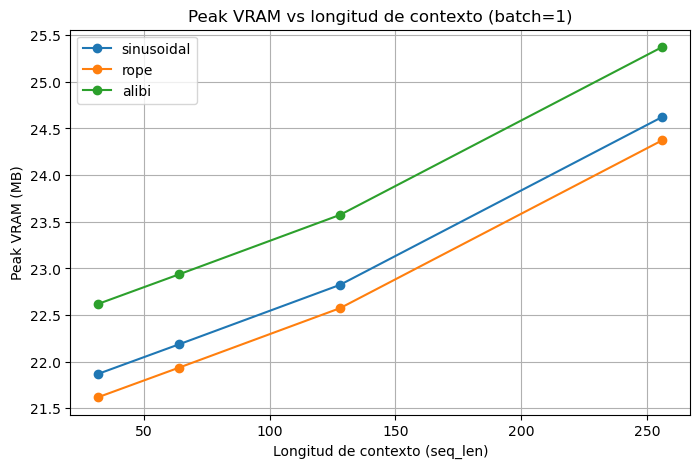

In [7]:

if perf_all is not None:
    plt.figure(figsize=(8, 5))
    for posenc in perf_all["posenc_type"].unique():
        df_ = perf_all[(perf_all["posenc_type"] == posenc) &
                       (perf_all["batch_size"] == 1)]
        plt.plot(df_["seq_len"], df_["peak_mem_mb"], "o-", label=posenc)

    plt.xlabel("Longitud de contexto (seq_len)")
    plt.ylabel("Peak VRAM (MB)")
    plt.title("Peak VRAM vs longitud de contexto (batch=1)")
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    print("No hay datos de perf para graficar.")


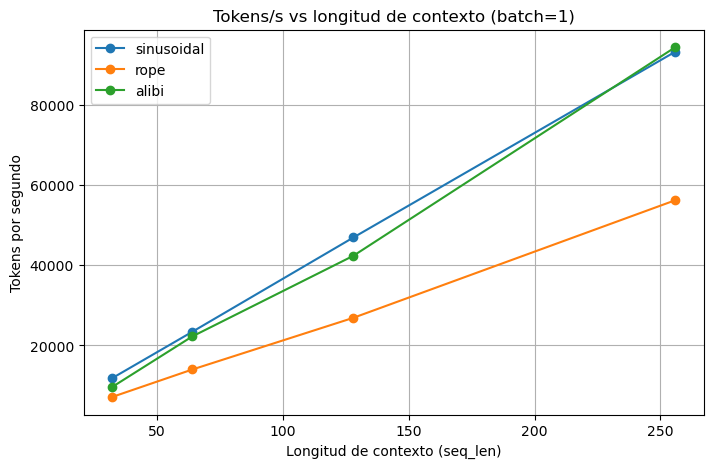

In [8]:

if perf_all is not None:
    plt.figure(figsize=(8, 5))
    for posenc in perf_all["posenc_type"].unique():
        df_ = perf_all[(perf_all["posenc_type"] == posenc) &
                       (perf_all["batch_size"] == 1)]
        plt.plot(df_["seq_len"], df_["tokens_per_s"], "o-", label=posenc)

    plt.xlabel("Longitud de contexto (seq_len)")
    plt.ylabel("Tokens por segundo")
    plt.title("Tokens/s vs longitud de contexto (batch=1)")
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    print("No hay datos de perf para graficar.")
